<hr>
Este material ha sido construido en conjunto con material suministrado por los profesores Pedro Atencio (Instituto Tecnológico Metropolitano), Carlos Mera (Universidad de Medellin), Albeiro Espinosa y Diego Patiño (Universidad Nacional de Colombia, Sede Medellín); a ellos les damos crédito.
<hr>

#  <center> VISIÓN ARTIFICIAL </center>
## Agenda del día


### Unidad 6 - Convolución y filtrado espacial


<ul>
<li>Operaciones por vecindad</li>
<li>Filtros espaciales</li>


</ul>

<img src="res/pipeline.png"/>

El objetivo del preprocesamiento es mejorar la calidad y/o la apariencia de la imagen original para su análisis e interpretación.

Se resaltan ciertas características de la imagen (bordes, contraste, …) y se ocultan o eliminan otras  (por ejemplo, el ruido)

El preprocesamiento es una etapa previa que es necesaria para otras fases posteriores del proceso de visión artificial (segmentación, extracción de características, reconocimiento e interpretación).


<img src="res/prepro.png">

En esta ocasión nos centraremos en las operaciones de transformación por vecindario.



In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#En este notebook se define una función que facilita la lectura de imágenes
#Leer la imagen en RGB o escala de grises con una sola línea de código
def img_read(filename, mode = 'color'):
    if(mode == 'color'):
        return cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB)
    elif(mode=='grayscale' or mode=='greyscale' or mode == 'gray' or mode == 'grey'):
        return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        return None

# 1. Operaciones por Vecindad y Convolución
Este tipo de transformaciones operan sobre un conjunto de valores sobre el pixel principal. Su propósito es resaltar o atenuar los detalles espaciales de la imagen para mejorar su interpretación visual o facilitar su procesamiento posterior. Para ello se usan diferentes mascaras de convolución, que pueden expresarse de la siguiente forma:

$$G(x,y) = f(I(x-k, y-k),...,I(x+k,y+k))$$
Donde k, se refiere al radio de una ventana alrededor del píxel central en la posición (x,y).
<br>
<center><i>Figura. Convolución con kernel. Tomada de <a href='https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/ConvolutionOperations/ConvolutionOperations.html'>apple developer.</a></i>

<img src="res/convolucion/image_convolution.jpg" alt="operaciones" style="height:400px"></img></center>
<br>
Si bien una convolución se puede realizar solo con los valores de la imagen de entrada I, su expresión general requiere de un kernel de convolución, el cual es una matriz usualmente cuadrada de menor tamaño que la imagen que se está operando. En este caso, la operación de convolución en su forma general queda expresada como:

$$G(x,y)=\sum_{i=-k}^{k}\sum_{j=-k}^{k}I(x+i,y+j)*w(k+i, k+j)$$

Donde k es el radio del kernel de convolución w, cuyo tamaño es cuadrado e impar.
<hr>
<center><i>Figura. Definición matemática.</i>

<img src="res/convolucion/mat.png" alt="operaciones" style="height:400px"></img></center>

## 1.1 Propiedades de la convolución
***Linealidad de la Convolución:***

- $(a · I) ∗ H = a · (I ∗ H)$

- $(I_1 + I_2) ∗ H = (I_1 ∗ H) + (I_2 ∗ H)$

Esta propiedad permite que podemos multiplicar la imagen por una constante antes o después de convolución, y también que podemos sumar dos imágenes antes o después de la convolución y obtener los mismos resultados.

***Conmutatividad de la Convolución:***

- $I ∗ H = H ∗ I$

Esta propiedad indica que podemos pensar en la imagen como un kernel y en el kernel como la imagen y obtener el mismo resultado. En otras palabras, se puede dejar la imagen fija y deslizar el kernel o dejar el kernel fijo y deslizar la imagen.

***Asociatividad de la Convolución:***

- $(I ∗ H_1 ) ∗ H_2 = I ∗ (H_1 ∗ H_2 )$

Esto significa que podemos aplicar H1 a I seguido de H2, o podemos convolucionar los kernels H2 * H1 y luego aplicar la convolución resultante a I (solo aplica para convoluciones lineales)

<center><i>Figura.  Ejemplo de convolución. </i>

<img src="res/convolucion/ejconvo.png" alt="operaciones" style="height:400px"></img></center>

Realicemos una convolución rudimentaria para la imagen *img* en la posicion 1,1, es decir, *res(1,1)*

El resultado de aplicar la convolución en img(1,1) es: 181


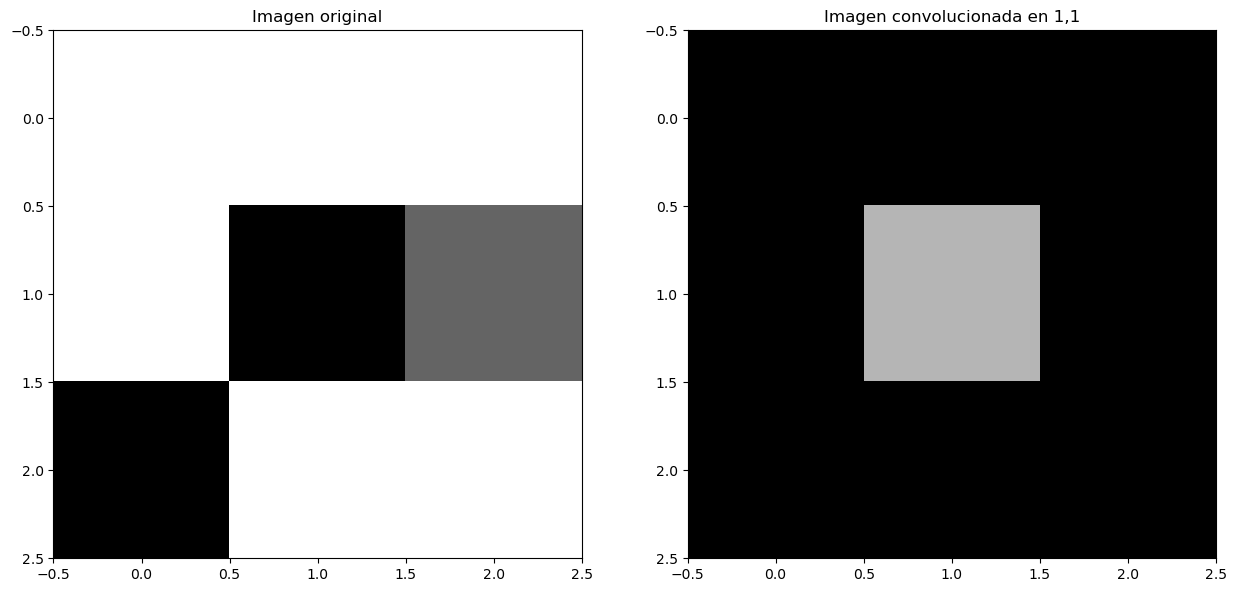

In [2]:
#Imagen de entrada, creada artificialmente
img = np.array([[255,255,255],
              [255,0,100],
              [0,255,255]], dtype=np.uint8)

#Posición (x,y)
x = 1
y = 1

#Máscara de convolución
w = np.array([[1/9,1/9,1/9],
              [1/9,1/9,1/9],
              [1/9,1/9,1/9]], dtype=np.float64)

k = 1 #el radio del kernel

#Crear una matriz de ceros del mismo tamaño de la imagen de entrada, datos flotantes
res = np.zeros(img.shape, dtype=np.float64)

#Recorrer todos los valores i,j de la imagen, en el intervalo del radio del kernel
for i in range(-k, k+1):
    for j in range(-k, k+1):
        #Resultado de la convolución en la posición 1,1
        res[1][1] += img[x+i][y+j] * w[k+i][k+j]

#Volver al tipo de dato uint8
res=res.astype(np.uint8)

print("El resultado de aplicar la convolución en img(1,1) es:", res[1][1])

#Generar subplot 1x2 para mostrar imagen original y convolucionada en 1,1
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen convolucionada en 1,1')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255);

Ahora implementemos para toda una imagen.

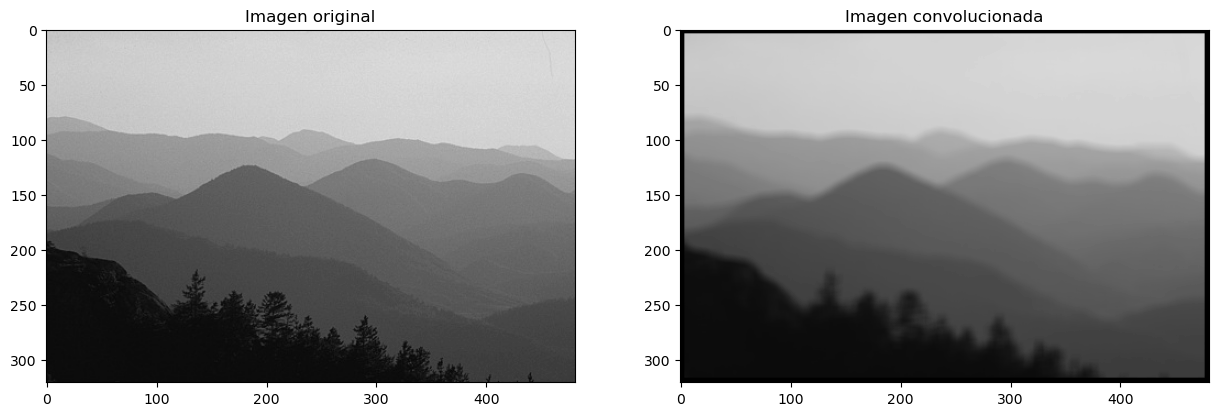

In [3]:
import math

#Función para hacer el kernel, su parámetro es el tamaño de éste
def make_kernel(size):
    #Matriz de unos del tamaño de entrada, datos de tipo flotante
    kernel = np.ones((size,size),dtype=np.float64)
    #r corresponde al entero más grande que sea menor o igual a size/2
    r = math.floor(size/2)
    return (r,kernel/(size**2))

#Función de aplicación de kernel sobre la imagen bajo los parámetros
#imagen de entrada, máscara, valores en x,y,kernel,r
def apply_kernel(img, res, x,y,kernel,r):
    #Recorrer la imagen en el intervalo del radio del kernel
    for i in range(-r, r+1):
        for j in range(-r, r+1):
            #Convolución sobre cada pixel de la imagen
            res[x][y] += img[x+i][y+j] * kernel[r+i][r+j]

#Leer la imagen
img = img_read('res/ruido/mountains.jpg', 'gray')
#Tamaño del kernel
k_size = 9
#Obtener un kernel que se ajusta al tamaño solicitado mediante la función
(r, kernel) = make_kernel(k_size)
#Crear la matriz de ceros del tamaño de la imagen de entrada, tipo de datos flotante
res = np.zeros(img.shape, dtype=np.float64)

#Realizar la operación convolución sobre toda la imagen de entrada
for i in range(r,img.shape[0]-r):
    for j in range(r, img.shape[1]-r):
        apply_kernel(img, res, i, j, kernel, r)

#Asegurar el tipo de dato uint8
res=res.astype(np.uint8)

#Generar un subplot 1x2 que muestre imagen original y la convolución
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen convolucionada')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255);

Podemos observar que los pixeles de borde que no se tocan quedan con valor 0.

## 1.2 Manejo de bordes

¿Qué sucede con los píxeles al borde de la imagen? Aplicar convolucion sobre una imagen, implica resolver el problema del padding o de los pixeles que se encuentran en los bordes, tales que el filtro de convolucion queda por fuera de dichos pixeles.
<center><i>Figura. Bordes.</i></center>
<img src="res/convolucion/bordes.png"/>

La solución más rudimentaria es empezar la convolución en la primera posición donde la ventana no sobresalga de la imagen (crop). En este caso, la imagen resultante será más pequeña que la original.

<center><i>Figura. Crop.</i></center>
<img src="res/convolucion/crop.png"/>

Existen diversas alternativas, todas más eficaces:
<ul>
    <li><b>Zero padding</b>: Se asignan nuevas columnas y filas en los bordes de la imagen y se les da el valor de cero. Esto con el fin de que no se utilicen los valores del kernel de convolucion por fuera de la imagen, pero que no haya errores de indices por fuera de la imagen.</li>
    <br>
    <li><b>Constant Padding</b>: En este caso se asigna un valor constante a los pixeles agregados en el borde.</li>
    <br>
    <li><b>Nearest Neighbor</b>: Se utiliza el valor de mas cercano para llenar los pixeles por fuera de la imagen.</li>
    <br>
    <li><b>Reflect</b>: Se repiten las columnas o las filas de la imagen en forma reflejada para los pixeles por fuera de ella.</li>
        <br>
    <li><b>Wrap</b>: Se repiten las columnas o las filas de la imagen con base en el extremo opuesto de la imagen.</li>
</ul>
<center><i>Figura. Padding.</i></center>
<img src="res/convolucion/padding.jpg" alt="operaciones" style="height:700px"></img>
<br>
<hr>


OpenCV implementa todas las alternativas de padding mencionadas arriba.

* BORDER_CONSTANT
* BORDER_REPLICATE
* BORDER_REFLECT
* BORDER_WRAP

https://vovkos.github.io/doxyrest-showcase/opencv/sphinx_rtd_theme/enum_cv_BorderTypes.html

La función copyMakeBorder de OpenCV nos genera una copia de la imagen con los bordes que necesitamos:

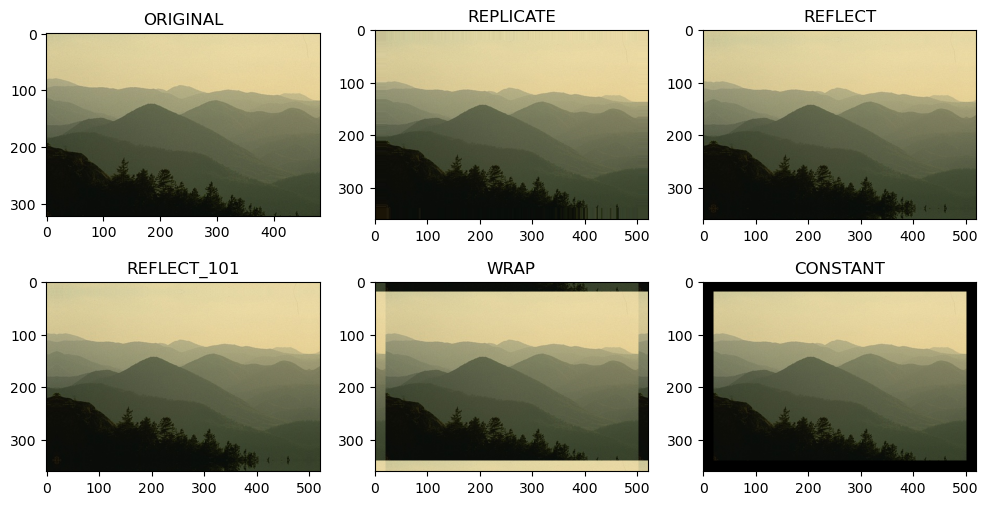

In [4]:
#Leer imagen de entrada
img = img_read('res/ruido/mountains.jpg', 'color')

#Asignar un valor al tamaño del borde en las 4 direcciones
#up,down,left,right
b_sz = 20

#Aplicar MakeBorder bajo todas las alternativas (último parámetro)
replicate = cv2.copyMakeBorder(img,b_sz,b_sz,b_sz,b_sz,cv2.BORDER_REPLICATE)
reflect = cv2.copyMakeBorder(img,b_sz,b_sz,b_sz,b_sz,cv2.BORDER_REFLECT)
reflect101 = cv2.copyMakeBorder(img,b_sz,b_sz,b_sz,b_sz,cv2.BORDER_REFLECT_101)
wrap = cv2.copyMakeBorder(img,b_sz,b_sz,b_sz,b_sz,cv2.BORDER_WRAP)
constant= cv2.copyMakeBorder(img,b_sz,b_sz,b_sz,b_sz,cv2.BORDER_CONSTANT,value=[0,0,0])

#Generar 6 figuras para mostrar cada una de las alternativas y la imagen original
fig = plt.figure(figsize=(12,6))
plt.subplot(231),plt.imshow(img,'gray'),plt.title('ORIGINAL')
plt.subplot(232),plt.imshow(replicate,'gray'),plt.title('REPLICATE')
plt.subplot(233),plt.imshow(reflect,'gray'),plt.title('REFLECT')
plt.subplot(234),plt.imshow(reflect101,'gray'),plt.title('REFLECT_101')
plt.subplot(235),plt.imshow(wrap,'gray'),plt.title('WRAP')
plt.subplot(236),plt.imshow(constant,'gray'),plt.title('CONSTANT');

Para utilizar padding con un kernel arbitrario, podemos utilizar la función cv2.filter2D, que recibe la imagen original, un parámetro de profundidad que se mantiene en -1, el kernel y el tipo de borde que deseemos.

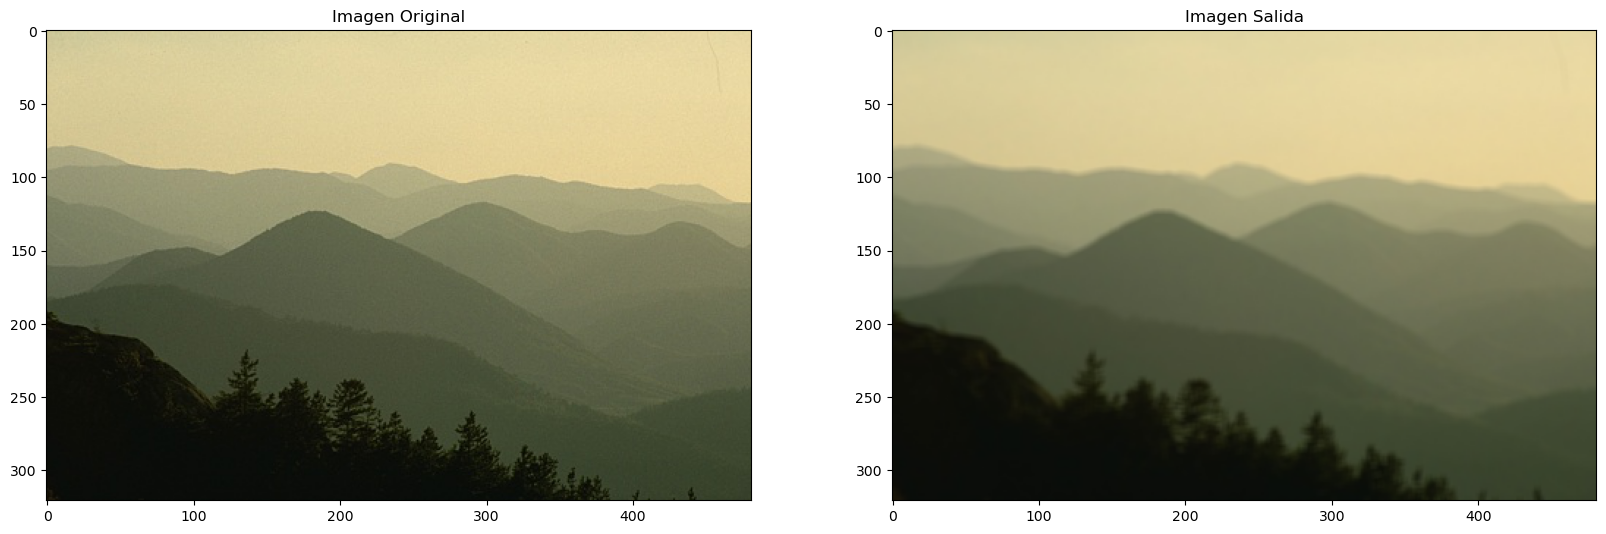

In [5]:
#Leer la imagen de entrada
img = img_read('res/ruido/mountains.jpg', 'color')

#Crear un kernel de tamaño 5
k_size = 5
kernel = np.ones((k_size,k_size),np.float64)/(k_size**2)

#Aplicar filter2D sobre la imagen y el kernel arbitrario, bajo la alternativa de borde preferida
res = cv2.filter2D(img, ddepth=-1, kernel= kernel, borderType=cv2.BORDER_REPLICATE)

#Mostrar la imagen original y la imagen bajo filter2D
fig = plt.figure(figsize=(20,24))

plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.title("Imagen Original")

plt.subplot(1,2,2)
plt.imshow(res,cmap='gray')
plt.title("Imagen Salida");

# ¿Cómo se puede suprimir el Ruido en las imágenes?

Las técnicas de supresión del ruido están estrechamente relacionadas con los algoritmos de suavizado.

En general, las técnicas utilizadas para eliminar ruido son filtros. Existen dos categorías de filtros: filtros espaciales y filtros frecuenciales.


# 2. Filtrado Espacial
Los filtros son utilizados para remover ruido o impurezas indeseables de la imagen. Aunque existen también filtros para otras tareas tales como detectar bordes en la imagen, por ahora nos enfocaremos en filtros para limpiar el ruido de la imagen. Los filtros ya sean para ruido o para extraer bordes se pueden clasificar como filtros lineales o no-lineales. se dice que un filtro $f$ es lineal si:

$$f(x+y)=f(x)+f(y)$$
De otra manera, el filtro se considera no-lineal.

A continuación, algunos ejemplos de ambos filtros:

<ul>
<li><b>Filtros lineales</b></li>
    <ul>
       <li>Filtro de media</li>
       <li>Filtro Gaussiano</li>
    </ul>
<li><b>Filtros no-lineales</b></li>
    <ul>
       <li>Filtro de mediana</li>
       <li>Filtro de minimos</li>
       <li>Filtro de maximos</li>
    </ul>
</ul>

## 2.1 Filtros lineales de suavizado

Los Filtros de Suavizado (o Paso Bajo) se usan para suavizar los detalles de la imagen, reducir el ruido y atenuar otros detalles irrelevantes de la imagen.


***Filtro de media (mean filter):*** El filtro de suavizado más simple, intuitivo y fácil de implementar es el Filtro de la Media.
El filtro de media cumple con la funcion de suavizar u homogenizar la imagen y eliminar ruido.
¿Cómo funciona? Se visita cada píxel de la imagen  y se reemplaza por el promedio de los píxeles vecinos. Este filtro puede ser implementado mediante convolucion utilizando un kernel $w$ con coeficiente 1's y divido por el tamaño del mismo.
$$w = \frac{1}{9}\begin{bmatrix}1 & 1 & 1 \\ 1 & 1 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

En la ecuacion anterior tenemos el kernel de convolucion de un filtro de media de 3x3, por lo cual cada valor del kernel sera $\frac{1}{9}$. Si el caso fuera un kernel de 5x5 entonces tendriamos un valor de $\frac{1}{25}$ para cada elemento.

<center><i>Figura. Filtro de media.</i>

<img src="res/filtrado/media.png" alt="operaciones" style="height:200px"></img></center>

Dado que la media, como medida estadística, es sensible a los valores extremos, este filtro tiene a ser muy sensible a los cambios de intensidad en la vecindad.

Como se promedian los valores de intensidad de píxeles vecinos, existe la posibilidad de que se generen valores de grises que originalmente no se encontraban en la imagen.

El efecto de suavizado (o difuminado) se acentúa más conforme crece el tamaño de la mascara de convolución.
<hr>

Dado que la media, como medida estadística, es sensible a los valores extremos, este filtro tiene a ser muy sensible a los cambios de intensidad en la vecindad.

Como se promedian los valores de intensidad de píxeles vecinos, existe la posibilidad de que se generen valores de grises que originalmente no se encontraban en la imagen.

El efecto de suavizado (o difuminado) se acentúa más conforme crece el tamaño de la mascara de convolución.
<center><i>Figura. Filtro de media con diferentes tamaños de kernel.</i>

<img src="res/filtrado/media2.png" alt="operaciones" style="height:200px"></img></center>

El filtro de media se puede aplicar de varias formas:

* La implementación rudimentaria que hicimos al comienzo.
* La función cv2.blur, que implementa de forma automática el filtro de media.
* La función cv2.filter2D, que implementa un filtro arbitrario que recibe como kernel.
* La función box_filter, que se basa en el concepto de la imagen integral.

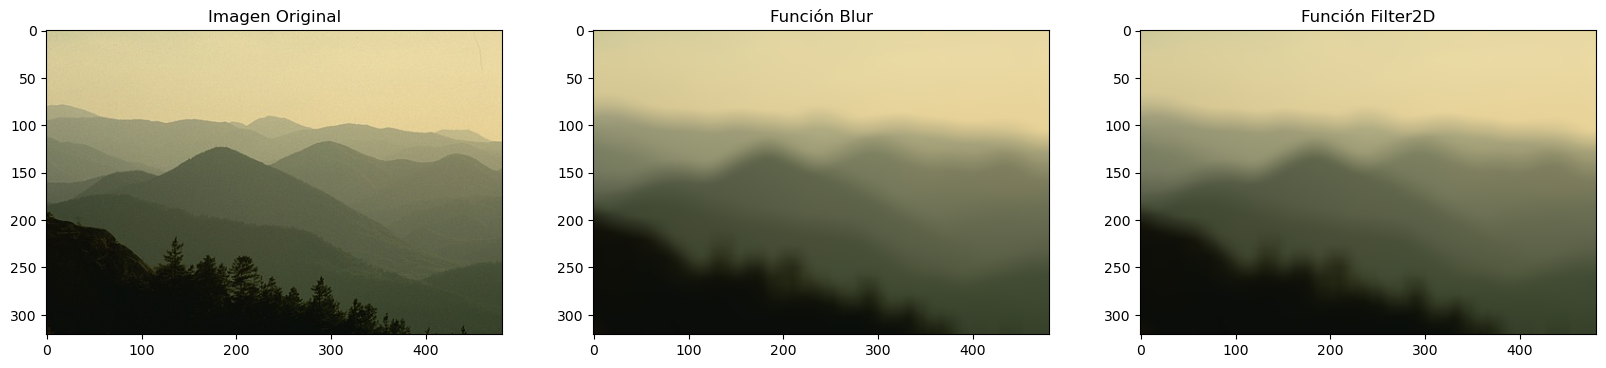

In [6]:
#Leer la imagen de entrada
img = img_read('res/ruido/mountains.jpg', 'color')

#Dar valor al tamaño del kernel
k_size = 25

#Aplicar suavizado mediante la función blur, con  un tipo de borde que puede cambiarse
res1 = cv2.blur(img,(k_size,k_size),borderType=cv2.BORDER_REPLICATE )

#Aplicar el suavizado mediante filter2D
kernel = np.ones((k_size,k_size),np.float64)/(k_size**2)
res2 = cv2.filter2D(img, ddepth=-1, kernel= kernel, borderType=cv2.BORDER_REPLICATE)

#Generar un subplot de 1x3 para mostrar imagen original, Blur y Filter2D
fig = plt.figure(figsize=(20,24))

plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.title("Imagen Original")

plt.subplot(1,3,2)
plt.imshow(res1,cmap='gray')
plt.title("Función Blur")

plt.subplot(1,3,3)
plt.imshow(res2,cmap='gray')
plt.title("Función Filter2D");

## 2.2 El box filter y la imagen integral
La implementación del box filter se basa en el concepto de la imagen integral. La imagen integral es, a grandes rasgos, una suma bidireccional de todos los valores de una imagen.

<center><i>Figura. Calculando la imagen integral.</i>

<img src="res/filtrado/imagen_integral.png" alt="operaciones" style="height:200px"></img></center>

Con base en una imagen integral, la sumatoria de los valores que se encuentran dentro de cualquier rectángulo dentro de la imagen original se puede calcular así:

<center><img src="res/filtrado/summed_area.png" alt="operaciones" style="height:200px"></img></center>

<center><img src="res/filtrado/integral_image2.png" style="width:200px" /></center>

Esto nos permite calcular la sumatoria de los valores alrededor de un píxel con tan solo dos restas y una suma. Para calcular el valor que se le asignaría al píxel en la imagen resultado simplemente se realiza una división.

Veamos a continuación una implementación del box filter (nótese que implementamos el filtro box sin padding, es decir, con 'crop').

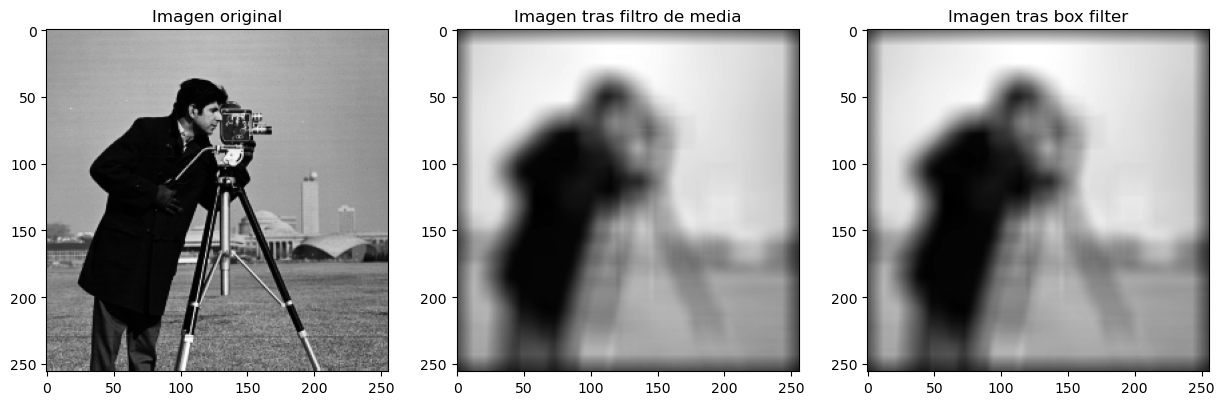

In [7]:
#Función imagen integral
def integralImage(img):
    """
    Returns the integral image/summed area table. See here: https://en.wikipedia.org/wiki/Summed_area_table
    :param img:
    :return:
    """
    #La función cumsum de numpy permite obtener la suma acumulativa de datos
    int_image = np.cumsum(img,0)
    int_image = np.cumsum(int_image,1)

    return int_image

#Función ajustar bordes
def adjustEdges(height, width, point):
    """
    This handles the edge cases if the box's bounds are outside the image range based on current pixel.
    :param height: Height of the image.
    :param width: Width of the image.
    :param point: The current point.
    :return:
    """
    #Definir un nuevo punto y verificar que esté dentro de la matriz de pixeles de la imagen
    #Así se asegura que la caja que contiene los datos esté contenida en la matriz
    newPoint = [point[0], point[1]]
    if point[0] >= height:
        newPoint[0] = height -1

    if point[1] >= width:
        newPoint[1] = width -1
    return tuple(newPoint)

#Encontrar el área de un paralelogramo
def findArea(int_img, a, b, c, d):
    """
    Finds the area for a particular square using the integral image. See summed area wiki.
    :param int_img: The
    :param a: Top left corner.
    :param b: Top right corner.
    :param c: Bottom left corner.
    :param d: Bottom right corner.
    :return: The integral image.
    """
    #El largo y el ancho del cuadrado se definen por los datos de la imagen de entrada
    height = int_img.shape[0]
    width = int_img.shape[1]

    #Aplicar la función ajustar bordes para asegurar que la caja esté dentro de la imagen
    a = adjustEdges(height, width, a)
    b = adjustEdges(height, width, b)
    c = adjustEdges(height, width, c)
    d = adjustEdges(height, width, d)

    #Condicionales que calculan la imagen integral sobre a,b,c,d si están dentro de la imagen
    a = 0 if (a[0] < 0 or a[0] >= height) or (a[1] < 0 or a[1] >= width) else int_img.item(a[0], a[1])
    b = 0 if (b[0] < 0 or b[0] >= height) or (b[1] < 0 or b[1] >= width) else int_img.item(b[0], b[1])
    c = 0 if (c[0] < 0 or c[0] >= height) or (c[1] < 0 or c[1] >= width) else int_img.item(c[0], c[1])
    d = 0 if (d[0] < 0 or d[0] >= height) or (d[1] < 0 or d[1] >= width) else int_img.item(d[0], d[1])

    return a + d - b - c

#Definir la caja que contiene los datos del filtrado
def boxFilter(img, filterSize):
    """
    Runs the subsequent box filtering steps. Prints original image, finds integral image, and then outputs final image
    :param img: An image in matrix form.
    :param filterSize: The filter size of the matrix
    :return: A final image written as finalimage.png
    """

    #Largo y ancho dependen de la imagen de entrada
    height = img.shape[0]
    width = img.shape[1]

    #Generar la imagen integral de la imagen de entrada
    intImg = integralImage(img)
    #Crear una copia de la imagen original
    res = np.ones((height, width), np.uint64)

    #Encontrar el mayor número entero de la matriz filterSize/2 (radio del kernel)
    loc = int(np.floor(filterSize/2))
    #Recorrer la imagen en todas las posiciones x,y
    for y in range(height):
        for x in range(width):
            #Itemset añade un valor a la matriz en la posición y,x
            #Aplicar findArea para encontrar el área del cuadrado bajo los parámetros de entrada
            res.itemset((y, x), findArea(intImg, (y-loc-1, x-loc-1),
                                         (y-loc-1, x+loc),
                                         (y+loc, x-loc-1),
                                         (y+loc, x+loc))/(filterSize**2))
    return res

#Leer la imagen de entrada
img = img_read('res/camera.png', 'gray')
#Tamaño del kernel
k_size = 25

#Nota, en ambos casos se asumen 0s en los bordes.

#Aplicar blur(filtro de media) y el método boxFilter en la imagen de entrada
res1 = cv2.blur(img,(k_size,k_size),borderType=cv2.BORDER_CONSTANT )
res2 = boxFilter(img, k_size)
res3 = cv2.boxFilter(img,-1, (k_size,k_size), normalize=True)

#Generar un subplot 1x3 para mostrar imagen original y filtradas
fig, arreglo_plots = plt.subplots(1,3, figsize=(15, 15))
arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray")

arreglo_plots[1].set_title('Imagen tras filtro de media')
arreglo_plots[1].imshow(res1, cmap="gray")

arreglo_plots[2].set_title('Imagen tras box filter')
arreglo_plots[2].imshow(res2, cmap="gray");

Existen otras máscaras para el Filtro de la Media que son “ponderadas”, es decir, le dan más importancia a ciertos píxeles:

<center><i>Figura. Filtros ponderados.</i>

<img src="res/filtrado/media_ponderada.png"></center>

En algunos casos puede resultar útil aplicar filtros de forma direccional y con otros tipos de ventana:

<center><i>Figura. Filtros vertical y horizontal.</i></center>

<br>

<center><img src="res/filtrado/media_verhor.png">
<img src="res/filtrado/media_verhor2.png"></center>
<br>

<center><i>Figura. Tipos de ventanas.</i>

<img src="res/filtrado/ventanas.png" alt="operaciones" style="height:200px"></img></center>
<hr>

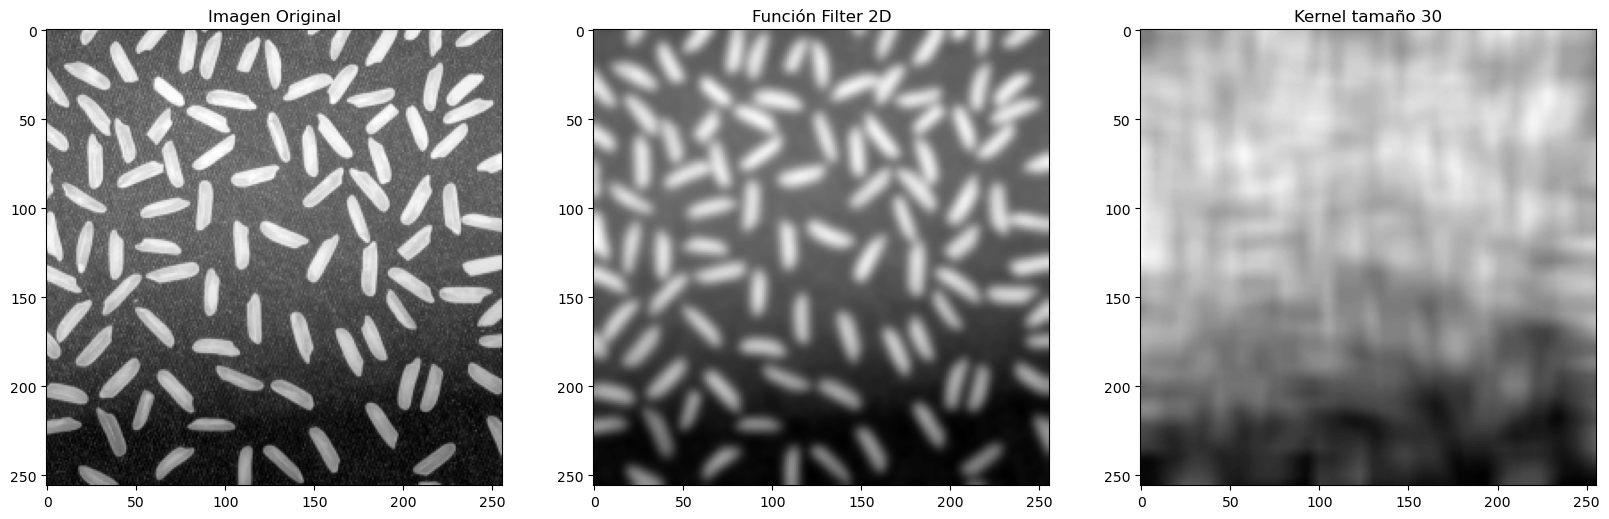

In [8]:
img = img_read('res/rice.png', 'gray')

k_size = 3

# Aplicar el mismo kernel 10 veces
kernel = np.ones((k_size,k_size),np.float64)/(k_size**2)
res2 = img.copy()
for i in range(0,10):
    res2 = cv2.filter2D(res2, ddepth=-1, kernel= kernel, borderType=cv2.BORDER_REPLICATE)

# Aplicar un kernel de un tamaño 10 veces mayor
k_size = k_size*10
kernel = np.ones((k_size,k_size),np.float64)/(k_size**2)
res3 = cv2.filter2D(img, ddepth=-1, kernel= kernel, borderType=cv2.BORDER_REPLICATE)

fig = plt.figure(figsize=(20,24))

plt.subplot(1,3,1)
plt.imshow(img,cmap='gray')
plt.title("Imagen Original")

plt.subplot(1,3,2)
plt.imshow(res2,cmap='gray')
plt.title("Función Filter 2D")

plt.subplot(1,3,3)
plt.imshow(res3,cmap='gray')
plt.title("Kernel tamaño 30");

## 2.3 Filtro gaussiano
En este caso, el núcleo de la convolución es una matrix con valores provenientes de una distribución Gaussiana 2-D, de media 0 y desviación estándar $\sigma$. De esta forma se mapean los valores de los vecinos respecto al valor central, siendo este ultimo el valor mas importante y los vecinos menos, es proporcional a la distancia respecto al pixel central:

$$f(x,y)={\frac{1}{2\pi\sigma^2}}e^-\frac{i^2+j^2}{2\sigma^2}$$

Una vez se crea el kernel de convolución Gaussiano mediante la ecuacion anterior, se procede a realizar convolución.


<center><i>Figura. Kernel de convolucion Gaussiano.</i>

<img src="res/filtrado/gauss.png" alt="operaciones" style="height:300px"></img></center>

Algunas de las propiedades del Filtro Gaussiano son:

* Su simetría rotacional lo que permite que el filtro tenga el mismo efecto en todas las direcciones

* El peso de los píxeles vecinos decrece con la distancia al centro, por lo que cuanto más alejado está un píxel, menos significativo es

* Preserva las bajas frecuencias y tiende a eliminar las altas (por ser un paso bajo)

* El grado de filtrado es controlado por σ, tal que a mayor σ mayor suavizado

* El ﬁltro Gaussiano, en general, da mejores resultados que un simple promedio o media y se argumenta que la vista humana hace un ﬁltrado de este tipo.

* Una de las ventajas del Filtro Gaussiano es que no produce los resultados “rectangulares” que suelen obtenerse con el Filtro de la Media cuando las máscaras son grandes:

<img src="res/filtrado/gaussvsmean.png" alt="operaciones" style="height:300px"></img>

A continuación utilicemos la implementación del filtro Gaussiano de OpenCV, la cual recibe como parámetros una tupla con la altura y el ancho del kernel, y la desviación estándar del mismo.

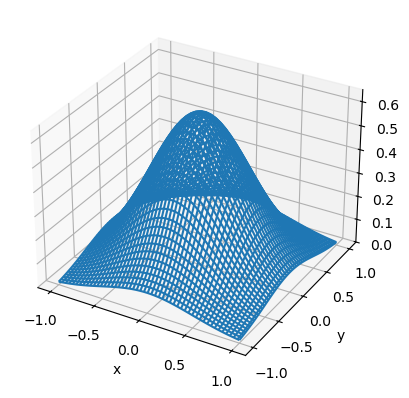

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

#Generar 2 vectores de 100 puntos entre -1 y 1
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

#Generar una malla a partir de los linspace, es cuadrada
X, Y = np.meshgrid(x, y)

#Se necesita un array de (N, 2) con (x, y) pares ordenados.
XY_pairs = np.column_stack([X.flat, Y.flat])

#Definir la media, sigma y covarianza de ambos vectores en x e y
mu = np.array([0.0, 0.0])
sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

#Crear una distribución normal multivariada
Z = multivariate_normal.pdf(XY_pairs, mean=mu, cov=covariance)

#Z debe tener el tamaño original de los vectores x e y
Z = Z.reshape((x.shape[0], y.shape[0]))

#Mostrar la distribución multivariada en una figura tridimensional
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

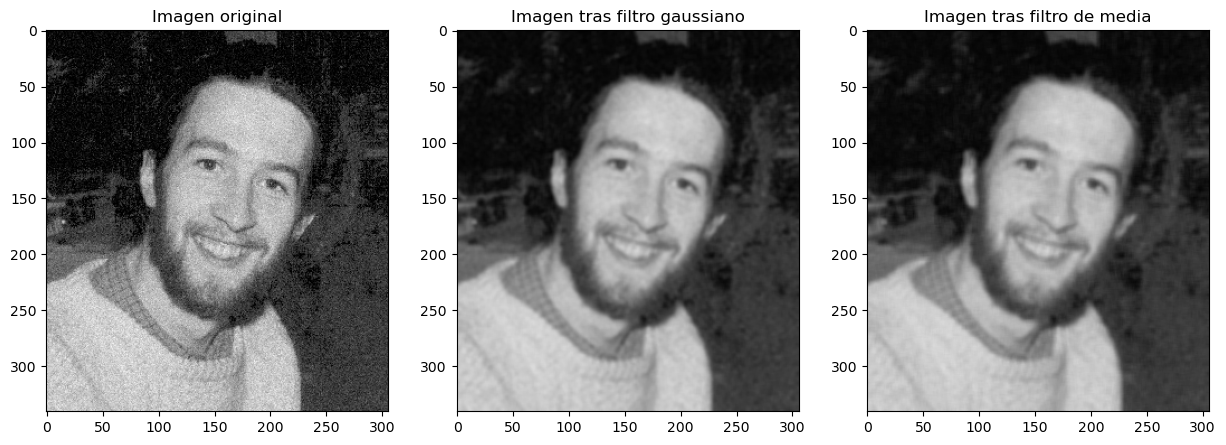

In [10]:
#Leer imagen de entrada
img = img_read('res/ruidoGaussiano.png', 'color')
#Definir tamaño del kernel
k_size = 5

#Aplicar un filtro Gaussiano con OpenCV a la imagen de entrada
res= cv2.GaussianBlur(img, (k_size,k_size), 2) # Sigma = 2 (desviación estandar)

#Aplicar un filtro de media a la imagen de entrada
res2 = cv2.blur(img, (k_size,k_size))

#Generar un subplot 1x3 que muestra imagen original y filtradas
fig, arreglo_plots = plt.subplots(1,3, figsize=(15, 15))
arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray")

arreglo_plots[1].set_title('Imagen tras filtro gaussiano')
arreglo_plots[1].imshow(res, cmap="gray")

arreglo_plots[2].set_title('Imagen tras filtro de media')
arreglo_plots[2].imshow(res2, cmap="gray");

# 3. Filtros no-lineales de suavizado

Este tipo de filtro no cumple con la condiciones de linealidad de la convolución y por lo tanto no puede ser implementado mediante la misma. Sin embargo siguen utilizando operaciones por vecindad para operar.
<br><br>


## 3.1 Filtro de mediana
La mediana de un conjunto de datos se entiende como el punto medio del conjunto ordenado de datos, es decir, para calcular la misma se debe:
<ul>
    <li>Tomar el conjunto de datos de la ventana centrada sobre el pixel en la posicion actual (x,y).</li>
    <li>Ordenar en forma ascendente el conjunto de datos.</li>
    <li>Tomar el valor medio en caso de que el conjunto de datos tenga un tamaño impar, o el promedio de los dos valores centrales si el tamaño es par.</li>
</ul>
<center><i>Figura. Filtro de mediana.</i></center>
<img src="res/filtrado/mediana.png" alt="operaciones" style="height:200px"></img>
<br>
Entre las ventajas de utilizar este filtro tenemos:
<br>
<ul>
    <li>Elimina el ruido por impulso (sal y pimienta).</li>
    <li>Eliminar efectos engañosos.</li>
    <li>Preserva bordes en la imagen.</li>
</ul>
<br>

Entre las desventajas podemos encontrar que:
<br>
<ul>
    <li>Pierde detalles (puntos, lineas finas).</li>
    <li>Redondea las esquinas de los objetos.</li>
    <li>Genera desplazamientos en los bordes de los objetos.</li>
</ul>
<br>
<center><i>Figura. Ejemplo de filtro de mediana.</i>

<img src="res/filtrado/mediana_2.png" alt="operaciones" style="height:300px"></img></center>
<br>
<center><i>Figura. Ejemplo de filtro de mediana.</i>

<img src="res/filtrado/mediana_3.png" alt="operaciones" style="height:300px"></img></center>
<br>
<center><i>Figura. Ejemplo de filtro de mediana - tamaños de ventana.</i>

<img src="res/filtrado/mediana_4.png" alt="operaciones" style="height:300px"></img></center>

<hr>

### Analicemos

¿Qué diferencias existen entre el filtro de media y mediana en términos de su comportamiento frente el ruido?
<hr>

In [11]:
def sp_noise(img, amount=0.05):
    """
    Agrega ruido de sal y pimienta a una imagen en escala de grises o en color.
    :param img: imagen de entrada (numpy array).
    :param porcentaje: porcentaje de píxeles que se convertirán en ruido de sal o pimienta (valor entre 0 y 1).
    :return: imagen con ruido de sal y pimienta (numpy array).
    """
    img_ruido = img.copy()
    # Agregar ruido a cada canal de color por separado
    if len(img.shape) == 2:
        black = 0
        white = 255
    else:
        black = np.array([0, 0, 0], dtype='uint8')
        white = np.array([255, 255, 255], dtype='uint8')
    probs = np.random.random(img_ruido.shape[:2])
    img_ruido[probs < (amount / 2)] = black
    img_ruido[probs > 1 - (amount / 2)] = white
    return img_ruido

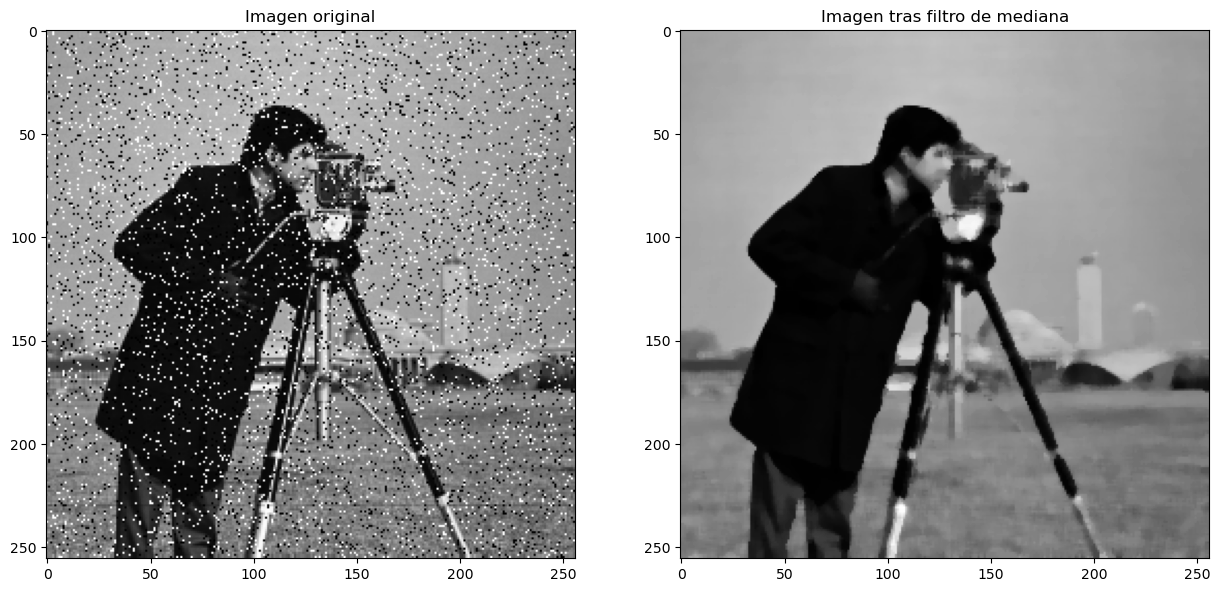

In [12]:
#Leer la imagen de entrada en escala de grises
img = img_read('res/camera.png', 'gray')
#Aplicar ruido sal y pimienta
img = sp_noise(img, amount = 0.1)

#Definir tamaño del kernel
k_size = 5
#Aplicar filtro de mediana a la imagen de entrada
res= cv2.medianBlur(img, k_size)

#Generar un subplot 1x2 para mostrar imagen original e imagen tras filtro de mediana
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))
arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray")

arreglo_plots[1].set_title('Imagen tras filtro de mediana')
arreglo_plots[1].imshow(res, cmap="gray");

## 3.2 Filtro de máximos
El Filtro del  Máximo selecciona el mayor valor dentro de una ventana ordenada de valores de nivel de gris.
<br><br>
<b>Ventajas</b>
<ul>
<li>Elimina el ruido pimienta (píxeles negros).</li>
</ul>
<br>
<b>Inconvenientes</b>
<ul>
<li>Sólo funciona cuando el ruido es exclusivamente tipo pimienta.</li>
<li>Tiende a aclarar la imagen.</li>
<ul>
<br>

<center><i>Figura. Ejemplo de filtro de máximos.</i>

<img src="res/filtrado/maximo.png" alt="maximo" style="height:200px"></img></center>

<center><i>Figura. Ejemplo de filtro de máximos.</i>

<img src="res/filtrado/maximo_2.png" alt="maximo" style="height:400px"></img></center>
<br>
<b>Consideraciones sobre el Filtro del Máximo</b>: el resultado es un cierto efecto de difuminado y aclaramiento de la imagen. Desaparecen los detalles más oscuros.
<ul>
<li>Si el tamaño es grande, pueden ocurrir dos efectos</li>
    <ul>
    <li>Efecto de cuadriculado. Como el máximo se aplica en una zona cuadrada, los píxeles muy claros generan un cuadrado uniforme alrededor.</li>
    <li>Aparición de colores falsos. Al aplicarlo en los tres canales (R,G,B) independientemente, el máximo en los 3 puede no corresponder a un color presente en la imagen original</li>
    </ul>
</ul>
<hr>

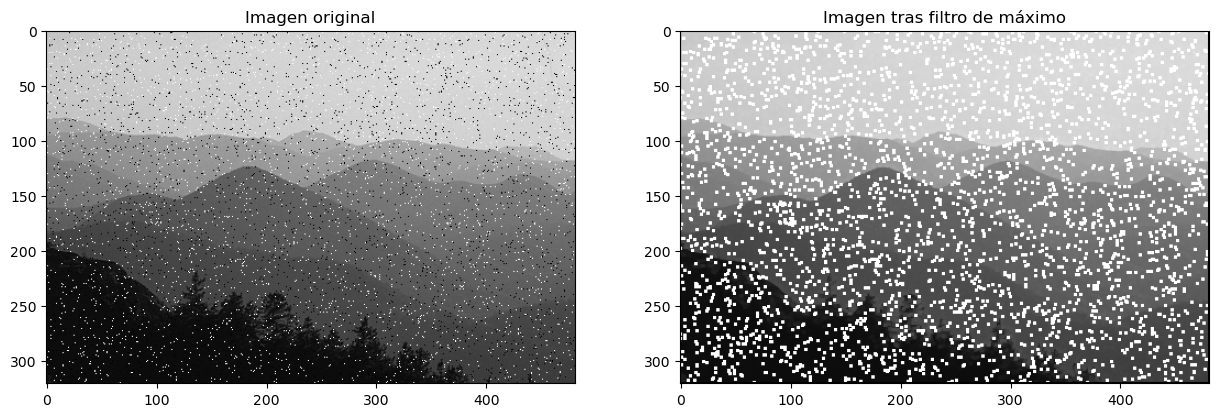

In [13]:
#Definir función de Filtro del Máximo
def maximum_filter(img,k_size):
    #Crear una matriz de ceros del tamaño de la imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Radio del kernel
    r = math.floor(k_size/2)
    #Recorrer cada posición i,j de la imagen con el kernel
    for i in range(r, img.shape[0]-r):
        for j in range(r, img.shape[1]-r):
            #Tamaño de la ventana
            window = img[i-r:i+r+1,j-r:j+r+1]
            #Cambiar el valor de la posición i,j de la imagen por el de la ventana
            max_val = np.max(window)
            res[i,j] = max_val
    return res

#Leer imagen de entrada
img = img_read('res/ruido/mountains.jpg', 'gray')

#Aplicar ruido sal y pimienta a la imagen
img = sp_noise(img,  amount = 0.04)
#Definir tamaño del kernel
k_size = 3

#Aplicar filtro del Máximo a la imagen
res = maximum_filter(img, k_size)
#Recordar el tipo de dato uint8, entre 0 y 255
res = res.astype(np.uint8)

#Generar un subplot 1x2 que muestre imagen original e imagen tras filtro de máximo
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen tras filtro de máximo')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255);

## 3.3 Filtro de mínimos
El Filtro del  Mínimo selecciona el menor valor dentro de una ventana ordenada de valores de nivel de gris.
<br><br>
<b>Ventajas</b>
<ul>
<li>Elimina el ruido sal (píxeles blancos).</li>
</ul>
<br>
<b>Inconvenientes</b>
<ul>
<li>Sólo funciona cuando el ruido es exclusivamente tipo sal.</li>
<li>Tiende a oscurecer la imagen.</li>
<ul>
<br>
<center><i>Figura. Ejemplo de filtro de minimos.</i>

<img src="res/m4/minimo.png" alt="minimo" style="height:200px"></img></center>
<br>
<center><i>Figura. Ejemplo de filtro de minimos.</i>

<img src="res/m4/minimo_2.png" alt="minimo" style="height:400px"></img></center>
<br>
<b>Consideraciones sobre el Filtro del Mínimo</b>: el resultado es un cierto efecto de oscurecimiento de la imagen. Desaparecen los detalles más claros.
<ul>
<li>Si el tamaño es grande, pueden ocurrir dos efectos</li>
    <ul>
    <li>Efecto de cuadriculado. Como el máximo se aplica en una zona cuadrada, los píxeles muy oscuros generan un cuadrado uniforme alrededor.</li>
    <li>Aparición de colores falsos. Al aplicarlo en los tres canales (R,G,B) independientemente, el máximo en los 3 puede no corresponder a un color presente en la imagen original</li>
    </ul>
</ul>
<hr>


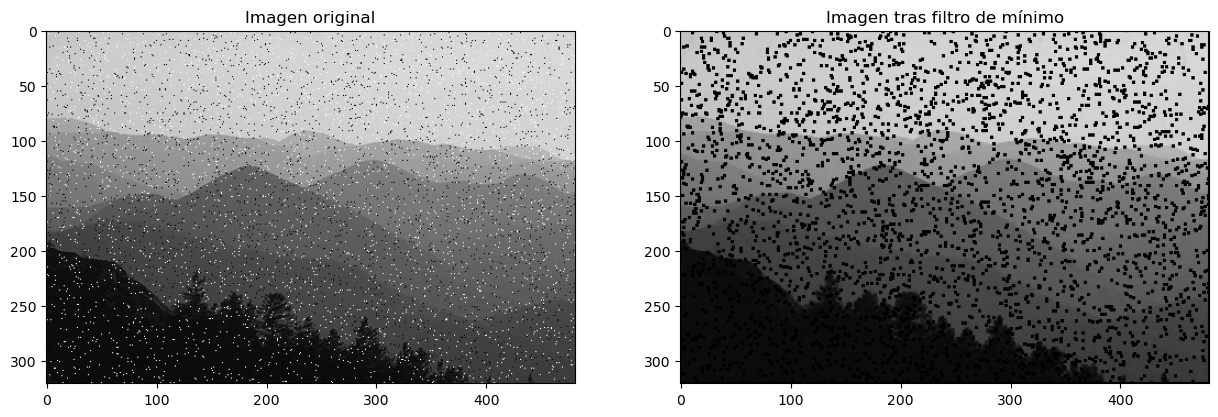

In [14]:
#Definir función filtro del mínimo
def minimum_filter(img,k_size):
    #Crear matriz de ceros del tamaño de imagen de entrada
    res = np.zeros(img.shape, np.uint8)
    #Definir el radio del kernel
    r = math.floor(k_size/2)
    #Recorrer cada posición i,j de la imagen con el kernel
    for i in range(r, img.shape[0]-r):
        for j in range(r, img.shape[1]-r):
            #Tamaño de la ventana
            window = img[i-r:i+r+1,j-r:j+r+1]
            #Cambiar el valor de la posición i,j de la imagen por el de la ventana
            min_val = np.min(window)
            res[i,j] = min_val
    return res

#Leer la imagen de entrada y aplicarle ruido sal y pimienta
img = img_read('res/ruido/mountains.jpg', 'gray')
img = sp_noise(img, amount = 0.04)
#Definir el radio del kernel
k_size = 3

#Aplicar filtro del mínimo a la imagen de entrada
res = minimum_filter(img, k_size)

#Tipo de dato entero, entre 0 y 255
res = res.astype(np.uint8)

#Generar subplot 1x2 para mostrar imagen original e imagen tras filtro del mínimo
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen tras filtro de mínimo')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255);

# 4. Filtros de suavizado avanzados

Existen en la literatura filtros de suavizado que pueden categorizarse como lineales o no-lineales pero con un planteamiento más avanzado que los mismos. Un objetivo usual de este tipo de filtros es conservar características particulares como son los bordes, que sufren un efecto de emborronamiento con la mayoría de filtros anteriormente mencionados.
<br>

## 4.1 Filtro bilateral
El filtro bilateral fue desarrollado para remover ruido preservando bordes. La operación es más lenta comparada a otros filtros. Se basa en el filtro Gaussiano, el cual como sabemos toma la veicindad del pixel y encuentra su promedio ponderado por una campana de Gauss. El filtro Gaussiano es función del espacio solamente, es decir, se consideran píxeles cercanos al filtrar. No se considera, por ejemplo, si los píxeles tienen el mismo valor de intensidad o si se encuentran o no en un borde. Esto resulta en un emborronamiento de los bordes, lo que es poco deseable en muchos casos de aplicación.

El filtro bilateral usa un filtro Gaussiano en el dominio espacial, pero además usa un componente multiplicativo Gaussiano adicional que es una función de las diferencias de intensidad entre píxeles. El componente espacial garantiza que los únicos píxeles considerados para el filtrado sean vecinos, mientras que el componente aplicado al dominio de intensidad (una función Gaussiana de las diferencias de intensidad) garantiza que los píxeles con intensidades similares a los del píxel central ('vecinos de intensidad') sean incluidos para computar el nuevo valor del mismo. Como resultado, el filtro preserva bordes, ya que para píxeles cercanos a los bordes que exhiben grandes variaciones de intensidad en contraste al píxel central, no se incluirán en la convolución.

/tmp/ipykernel_43706/453221216.py:30: RuntimeWarning: overflow encountered in scalar subtract
  gi = gaussian(source[neighbour_x][neighbour_y] - source[x][y], sigma_i)


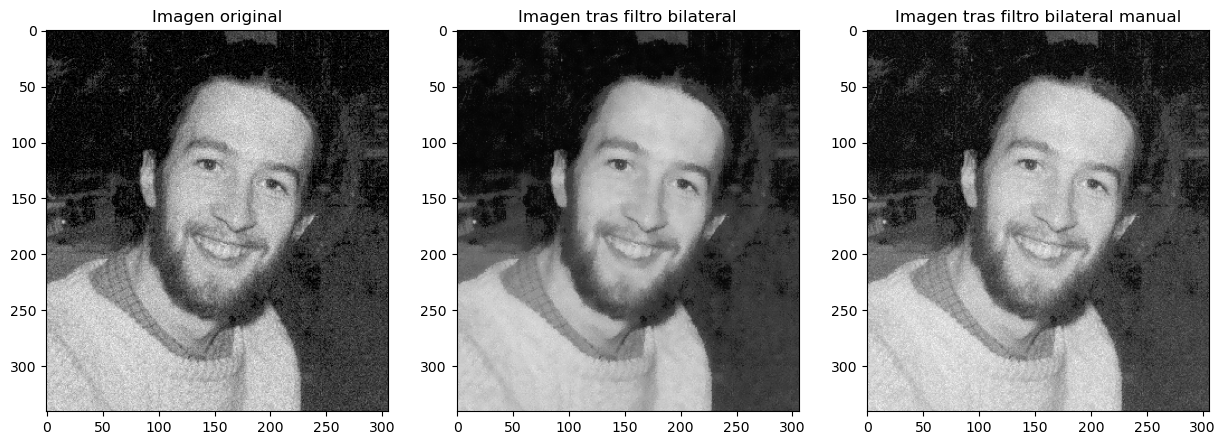

In [15]:
###Implementación tomada de: https://github.com/anlcnydn/bilateral/blob/master/bilateral_filter.py

#Función distancia euclídea
def distance(x, y, i, j):
    return np.sqrt((x-i)**2 + (y-j)**2)

#Distribución de probabilidad gaussiana
def gaussian(x, sigma):
    return float((1.0 / (2 * math.pi * (sigma ** 2))) * math.exp(- (x ** 2) / (2 * sigma ** 2)))

#Aplicar filtro bilateral a la entrada
def apply_bilateral_filter(source, filtered_image, x, y, diameter, sigma_i, sigma_s):
    #Operar con los parámetros de entrada
    hl = diameter//2
    i_filtered = 0
    Wp = 0
    #While hasta que i sea igual o mayor al diámetro definido
    i = 0
    #Operar sobre todos las posiciones i,j de la matriz de la imagen
    while i < diameter:
        j = 0
        while j < diameter:
            neighbour_x = x - (hl - i)
            neighbour_y = y - (hl - j)
            if neighbour_x >= len(source):
                neighbour_x -= len(source)
            if neighbour_y >= len(source[0]):
                neighbour_y -= len(source[0])
            #Aplicar la distribución gaussiana a los resultados obtenidos
            gi = gaussian(source[neighbour_x][neighbour_y] - source[x][y], sigma_i)
            gs = gaussian(distance(neighbour_x, neighbour_y, x, y), sigma_s)
            #Obtener el valor Wp que se muestra arriba
            w = gi * gs
            i_filtered += source[neighbour_x][neighbour_y] * w
            Wp += w
            j += 1
        i += 1
    #Finalmente, la imagen filtrada BF
    i_filtered = i_filtered / Wp
    filtered_image[x][y] = int(round(i_filtered))

#Función filtro bilateral
def bilateral_filter(source, filter_diameter, sigma_i, sigma_s):
    #Crear la imagen como matriz de ceros del tamaño de la imagen de entrada
    filtered_image = np.zeros(source.shape)
    #Ciclo que opera sobre las posiciones i,j de la imagen creada y la imagen de entrada
    i = 0
    while i < len(source):
        j = 0
        while j < len(source[0]):
            #Aplicar filtro bilateral a la imagen de entrada enm cada posición i,j
            apply_bilateral_filter(source, filtered_image, i, j, filter_diameter, sigma_i, sigma_s)
            j += 1
        i += 1
    return filtered_image

#Leer la imagen de entrada
img = img_read('res/ruidoGaussiano.png', 'gray')

#Tamaño del kernel
k_size = 9

#Filtro bilateral sobre la imagen de entrada
res = cv2.bilateralFilter(img,k_size,20, 75)
res2 = bilateral_filter(img,k_size,20,75) #SigmaColor: DE en intensidad, SigmaSpace: DE en espacio
#Tipo de dato uint8
res = res.astype(np.uint8)

#Generar subplot 1x2 para mostrar imagen original e imagen tras filtro bilateral
fig, arreglo_plots = plt.subplots(1,3, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen tras filtro bilateral')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255);

arreglo_plots[2].set_title('Imagen tras filtro bilateral manual')
arreglo_plots[2].imshow(res2, cmap="gray", vmin=0, vmax=255);

La implementación de manual arriba es ineficiente e imprecisa (amplifica ciertos puntos de ruido), pero sirve para demostrar los principios detrás del filtro bilateral. A continuación, usamos la implementación rápida de OpenCV:

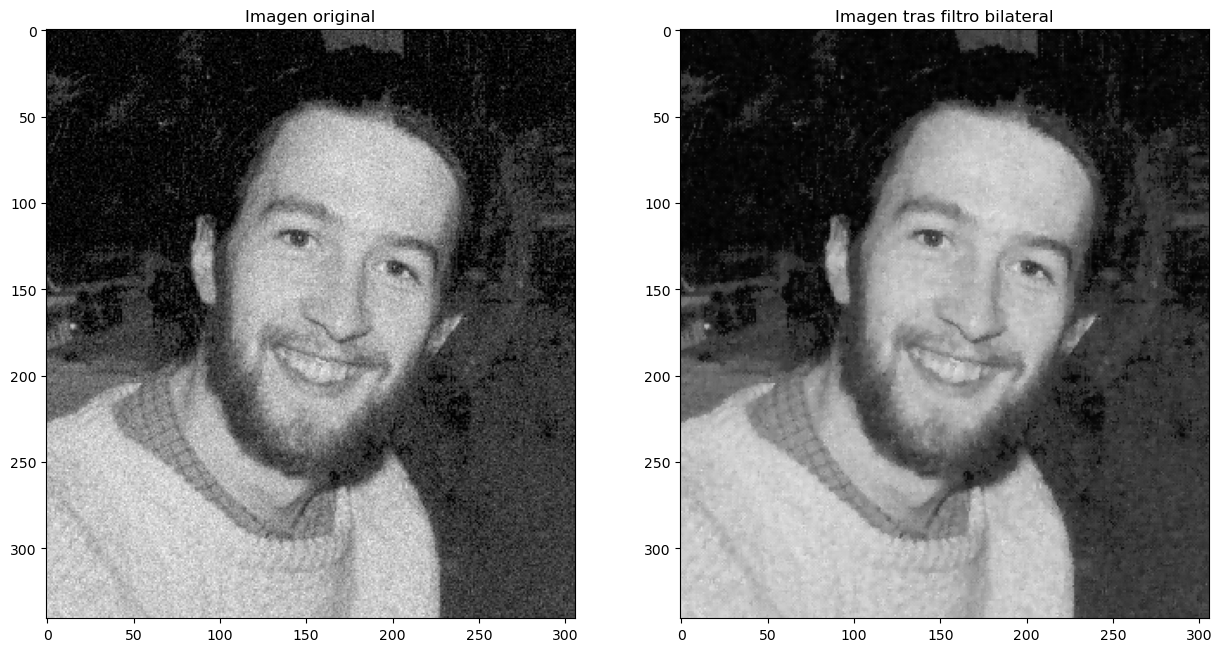

In [16]:
#Leer imagen de entrada
img = img_read('res/ruidoGaussiano.png', 'gray')

#Tamaño del kernel
k_size = 5

#Aplicar la función filtro bilateral de OpenCv y dar tipo de dato uint8
res = cv2.bilateralFilter(img,k_size, 20, 75)
res = res.astype(np.uint8)

#Generar subplot 1x2 para mostrar imagen original e imagen tras filtro bilateral
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen tras filtro bilateral')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255);

Para mayor información: http://people.csail.mit.edu/sparis/bf_course/

## 4.2 Filtro guiado

El filtro guiado se deriva de un modelo lineal local (el filtro caja/box). Este filtro computa la salida considerando el contenido de una imagen guía, la cual puede ser la imagen de entrada como tal o una imagen distinta. Aún en el caso el que la imagen guía es la imagen de entrada, el filtro guíado es capaz de conservar bordes como el filtro bilateral. El filtro guiado puede, además, transferir estructuras de la imagen guía a la imagen de salida, lo que permite aplicaciones como el la remoción de niebla y la reducción de ruido en duplas de imágenes con y sin flash. Asimismo, el filtro es extremadamente rápido y su tiempo de ejecución incrementa linealmente con el tamaño de las imágenes.

<center><i>Figura. Ejemplo de filtro guiado.</i>

<img src="res/guiado.png" alt="minimo" style="height:400px"></img></center>


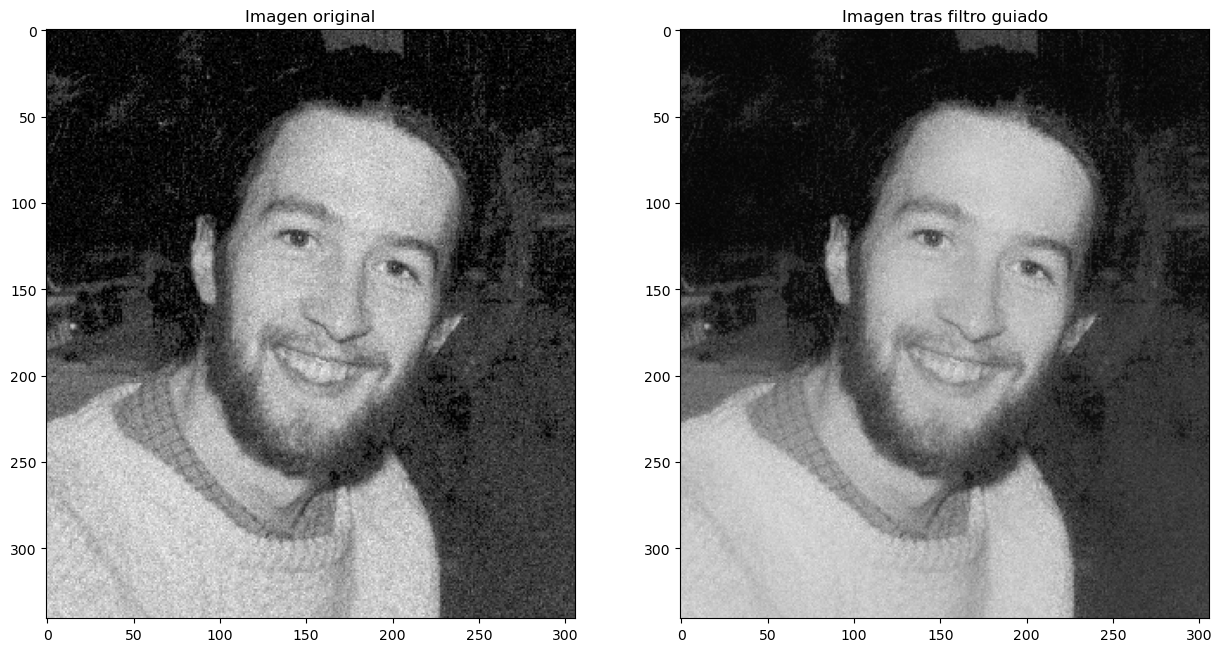

In [17]:
from cv2.ximgproc import guidedFilter

#Implementación de 0 (incluyendo la versión para imágenes a color) en: https://github.com/swehrwein/python-guided-filter/blob/master/gf.py
#En caso de que ocurra error por no tener los códigos propietarios de OpenCV, se puede probar con la implementación de arriba.

#Leer la imagen de entrada
img = img_read('res/ruidoGaussiano.png', 'gray')
#La imagen guía es la misma que la de entrada
img_guide = img

#Tamaño del kernel
k_size = 9

"""Aplicar el filtro guiado de OpenCv, donde 150 es el valor de epsilon, este es un parámetro de suavizado,
pues controla cuán fuertes deben ser las diferencias de intensidad para ser consideradas bordes significativos."""
res = guidedFilter(img_guide, img, k_size, 255 ,dDepth=-1)
#Tipo de dato uint8
res = res.astype(np.uint8)

#Generar subplot 1x2 para mostrar imagen original e imagen tras filtro guiado
fig, arreglo_plots = plt.subplots(1,2, figsize=(15, 15))

arreglo_plots[0].set_title('Imagen original')
arreglo_plots[0].imshow(img, cmap="gray", vmin=0, vmax=255)

arreglo_plots[1].set_title('Imagen tras filtro guiado')
arreglo_plots[1].imshow(res, cmap="gray", vmin=0, vmax=255);